<a href="https://colab.research.google.com/github/VanjaRadulovic/Duboko-Ucenje-Minijaturan-voice-assistant/blob/main/Projekat_2_Duboko_Ucenje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://docs.google.com/document/d/1CKPxN2VLzcFYRkJWq8jrsCgo_CoYo0k9hXq0AkEPAa4/edit?usp=sharing

LINK ZA DOKUMENTACIJU

In [ ]:
!git clone https://github.com/VanjaRadulovic/AudioFilesDeepLearning

Cloning into 'AudioFilesDeepLearning'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 467
Receiving objects: 100% (468/468), 32.21 MiB | 8.79 MiB/s, done.
Resolving deltas: 100% (170/170), done.


In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = 'AudioFilesDeepLearning/cmd'

data_dir = pathlib.Path(DATASET_PATH)

Importujemo podatke. Data set se sastoji od folder sa nazivom komande i audio fajlovima te komende. Napravili smo nas data set koji se sastoji iz jedne komande "Hello raf" i dataseta random zvukova koji nisu glas ako sto je muzika statika itd.

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['hello raf' 'noise']


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 16 files belonging to 2 classes.
Using 13 files for training.
Using 3 files for validation.

label names: ['hello raf' 'noise']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(13, 16000)
(13,)


Plotujemo nekoliko audio fajlova da vidimo kako izgledaju

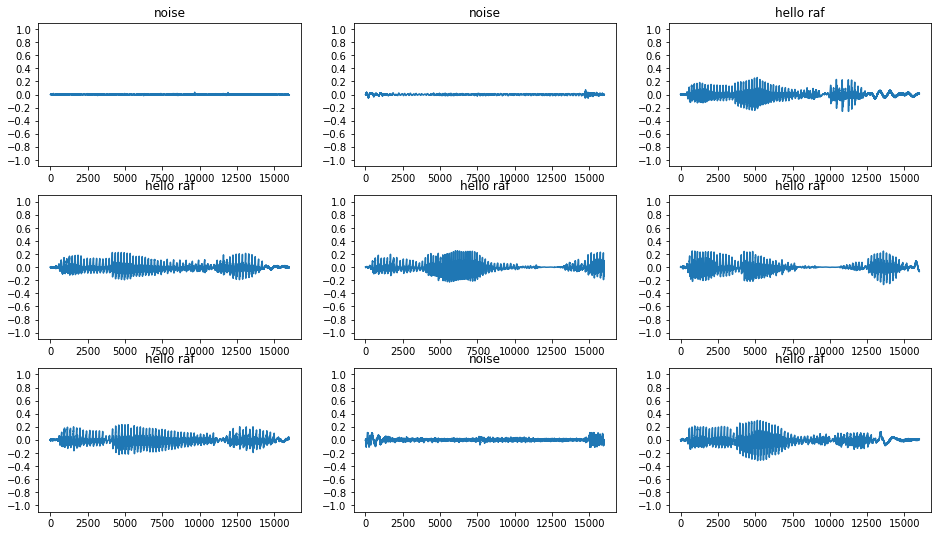

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [ ]:
def get_spectrogram(waveform):

  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: noise
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: noise
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: hello raf
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Definisemo funkciju za predstavljanje spektrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

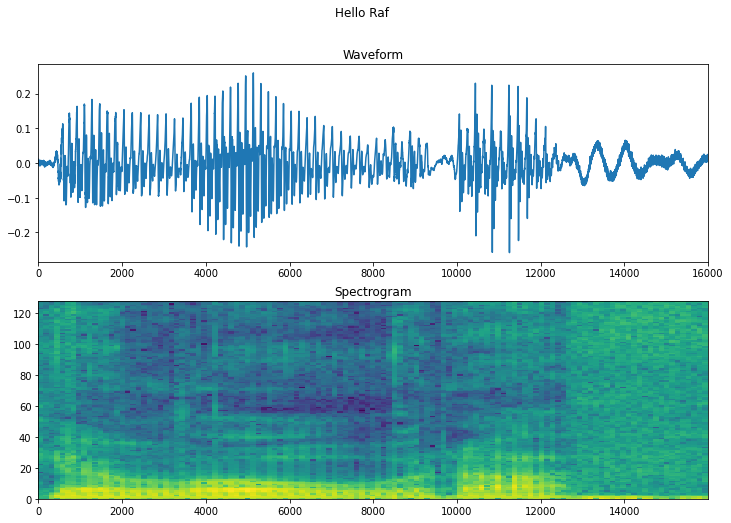

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Pravimo data set koji se sastoji od spektrograma

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

Build i train faza


In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Za model koristimo sekvencijalnu konvolucionu neuralnu mrezu, jer smo audio fajlove pretvorili u slike.

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Resizing(32, 32),

    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Treniramo model preko 250 epoha

In [ ]:
EPOCHS = 250
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/250
1/1 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.4615

1/1 [==============================] - 4s 4s/step - loss: 0.7384 - accuracy: 0.4615
Epoch 2/250
1/1 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.5385

1/1 [==============================] - 0s 74ms/step - loss: 0.5878 - accuracy: 0.5385
Epoch 3/250
1/1 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.7692

1/1 [==============================] - 0s 78ms/step - loss: 0.4146 - accuracy: 0.7692
Epoch 4/250
1/1 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 0.2683 - accuracy: 1.0000
Epoch 5/250
1/1 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 0.2003 - accuracy: 1.0000
Epoch 6/250
1/1 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 0.1491 - accuracy: 1.0000
Epoch 7/250
1/1 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 0.0390 - accuracy: 1.0000
Epoch 8/250
1/1 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 1.0000

1/1 [==============================] - 0s 84ms/step - loss: 0.0790 - accuracy: 1.0000
Epoch 9/250
1/1 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 10/250
1/1 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 0.0114 - accuracy: 1.0000
Epoch 11/250
1/1 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 12/250
1/1 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 13/250
1/1 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 14/250
1/1 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 15/250
1/1 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 16/250
1/1 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 17/250
1/1 [==============================] - ETA: 0s - loss: 8.6113e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 8.6113e-04 - accuracy: 1.0000
Epoch 18/250
1/1 [==============================] - ETA: 0s - loss: 6.5886e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 6.5886e-05 - accuracy: 1.0000
Epoch 19/250
1/1 [==============================] - ETA: 0s - loss: 5.2822e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 5.2822e-04 - accuracy: 1.0000
Epoch 20/250
1/1 [==============================] - ETA: 0s - loss: 2.5802e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 2.5802e-05 - accuracy: 1.0000
Epoch 21/250
1/1 [==============================] - ETA: 0s - loss: 1.7414e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 1.7414e-04 - accuracy: 1.0000
Epoch 22/250
1/1 [==============================] - ETA: 0s - loss: 5.7687e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 5.7687e-05 - accuracy: 1.0000
Epoch 23/250
1/1 [==============================] - ETA: 0s - loss: 2.7877e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 2.7877e-06 - accuracy: 1.0000
Epoch 24/250
1/1 [==============================] - ETA: 0s - loss: 3.7137e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 3.7137e-06 - accuracy: 1.0000
Epoch 25/250
1/1 [==============================] - ETA: 0s - loss: 2.1574e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 2.1574e-05 - accuracy: 1.0000
Epoch 26/250
1/1 [==============================] - ETA: 0s - loss: 2.4850e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 2.4850e-06 - accuracy: 1.0000
Epoch 27/250
1/1 [==============================] - ETA: 0s - loss: 6.4921e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 6.4921e-06 - accuracy: 1.0000
Epoch 28/250
1/1 [==============================] - ETA: 0s - loss: 4.6767e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 4.6767e-07 - accuracy: 1.0000
Epoch 29/250
1/1 [==============================] - ETA: 0s - loss: 6.4189e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 6.4189e-07 - accuracy: 1.0000
Epoch 30/250
1/1 [==============================] - ETA: 0s - loss: 1.3663e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 1.3663e-06 - accuracy: 1.0000
Epoch 31/250
1/1 [==============================] - ETA: 0s - loss: 9.9952e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 9.9952e-07 - accuracy: 1.0000
Epoch 32/250
1/1 [==============================] - ETA: 0s - loss: 2.1091e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 2.1091e-07 - accuracy: 1.0000
Epoch 33/250
1/1 [==============================] - ETA: 0s - loss: 8.1612e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 87ms/step - loss: 8.1612e-07 - accuracy: 1.0000
Epoch 34/250
1/1 [==============================] - ETA: 0s - loss: 3.8514e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 3.8514e-07 - accuracy: 1.0000
Epoch 35/250
1/1 [==============================] - ETA: 0s - loss: 2.0449e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 2.0449e-06 - accuracy: 1.0000
Epoch 36/250
1/1 [==============================] - ETA: 0s - loss: 1.3755e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 1.3755e-07 - accuracy: 1.0000
Epoch 37/250
1/1 [==============================] - ETA: 0s - loss: 3.5945e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 3.5945e-06 - accuracy: 1.0000
Epoch 38/250
1/1 [==============================] - ETA: 0s - loss: 1.8340e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 1.8340e-08 - accuracy: 1.0000
Epoch 39/250
1/1 [==============================] - ETA: 0s - loss: 9.1699e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 135ms/step - loss: 9.1699e-08 - accuracy: 1.0000
Epoch 40/250
1/1 [==============================] - ETA: 0s - loss: 7.0789e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 128ms/step - loss: 7.0789e-06 - accuracy: 1.0000
Epoch 41/250
1/1 [==============================] - ETA: 0s - loss: 5.5937e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 140ms/step - loss: 5.5937e-07 - accuracy: 1.0000
Epoch 42/250
1/1 [==============================] - ETA: 0s - loss: 1.7239e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 152ms/step - loss: 1.7239e-06 - accuracy: 1.0000
Epoch 43/250
1/1 [==============================] - ETA: 0s - loss: 3.5670e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 164ms/step - loss: 3.5670e-06 - accuracy: 1.0000
Epoch 44/250
1/1 [==============================] - ETA: 0s - loss: 1.8615e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 122ms/step - loss: 1.8615e-06 - accuracy: 1.0000
Epoch 45/250
1/1 [==============================] - ETA: 0s - loss: 1.3388e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 158ms/step - loss: 1.3388e-06 - accuracy: 1.0000
Epoch 46/250
1/1 [==============================] - ETA: 0s - loss: 1.3755e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 178ms/step - loss: 1.3755e-07 - accuracy: 1.0000
Epoch 47/250
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

1/1 [==============================] - 0s 182ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 48/250
1/1 [==============================] - ETA: 0s - loss: 4.3099e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 135ms/step - loss: 4.3099e-07 - accuracy: 1.0000
Epoch 49/250
1/1 [==============================] - ETA: 0s - loss: 1.3461e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 126ms/step - loss: 1.3461e-05 - accuracy: 1.0000
Epoch 50/250
1/1 [==============================] - ETA: 0s - loss: 1.7423e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 141ms/step - loss: 1.7423e-07 - accuracy: 1.0000
Epoch 51/250
1/1 [==============================] - ETA: 0s - loss: 2.7510e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 185ms/step - loss: 2.7510e-08 - accuracy: 1.0000
Epoch 52/250
1/1 [==============================] - ETA: 0s - loss: 5.5384e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 156ms/step - loss: 5.5384e-06 - accuracy: 1.0000
Epoch 53/250
1/1 [==============================] - ETA: 0s - loss: 8.2529e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 218ms/step - loss: 8.2529e-08 - accuracy: 1.0000
Epoch 54/250
1/1 [==============================] - ETA: 0s - loss: 8.3627e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 122ms/step - loss: 8.3627e-06 - accuracy: 1.0000
Epoch 55/250
1/1 [==============================] - ETA: 0s - loss: 1.5500e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 150ms/step - loss: 1.5500e-04 - accuracy: 1.0000
Epoch 56/250
1/1 [==============================] - ETA: 0s - loss: 1.9786e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 167ms/step - loss: 1.9786e-05 - accuracy: 1.0000
Epoch 57/250
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

1/1 [==============================] - 0s 192ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 58/250
1/1 [==============================] - ETA: 0s - loss: 8.5280e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 148ms/step - loss: 8.5280e-07 - accuracy: 1.0000
Epoch 59/250
1/1 [==============================] - ETA: 0s - loss: 1.1004e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 149ms/step - loss: 1.1004e-07 - accuracy: 1.0000
Epoch 60/250
1/1 [==============================] - ETA: 0s - loss: 1.5589e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 111ms/step - loss: 1.5589e-07 - accuracy: 1.0000
Epoch 61/250
1/1 [==============================] - ETA: 0s - loss: 1.7247e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 131ms/step - loss: 1.7247e-05 - accuracy: 1.0000
Epoch 62/250
1/1 [==============================] - ETA: 0s - loss: 1.7148e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 149ms/step - loss: 1.7148e-06 - accuracy: 1.0000
Epoch 63/250
1/1 [==============================] - ETA: 0s - loss: 3.1178e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 158ms/step - loss: 3.1178e-07 - accuracy: 1.0000
Epoch 64/250
1/1 [==============================] - ETA: 0s - loss: 6.4190e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 181ms/step - loss: 6.4190e-08 - accuracy: 1.0000
Epoch 65/250
1/1 [==============================] - ETA: 0s - loss: 9.1699e-09 - accuracy: 1.0000

1/1 [==============================] - 0s 196ms/step - loss: 9.1699e-09 - accuracy: 1.0000
Epoch 66/250
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

1/1 [==============================] - 0s 142ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 67/250
1/1 [==============================] - ETA: 0s - loss: 9.1699e-09 - accuracy: 1.0000

1/1 [==============================] - 0s 119ms/step - loss: 9.1699e-09 - accuracy: 1.0000
Epoch 68/250
1/1 [==============================] - ETA: 0s - loss: 5.5020e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 142ms/step - loss: 5.5020e-07 - accuracy: 1.0000
Epoch 69/250
1/1 [==============================] - ETA: 0s - loss: 7.3082e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 136ms/step - loss: 7.3082e-06 - accuracy: 1.0000
Epoch 70/250
1/1 [==============================] - ETA: 0s - loss: 2.0174e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 123ms/step - loss: 2.0174e-07 - accuracy: 1.0000
Epoch 71/250
1/1 [==============================] - ETA: 0s - loss: 6.4190e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 118ms/step - loss: 6.4190e-08 - accuracy: 1.0000
Epoch 72/250
1/1 [==============================] - ETA: 0s - loss: 2.3842e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 235ms/step - loss: 2.3842e-07 - accuracy: 1.0000
Epoch 73/250
1/1 [==============================] - ETA: 0s - loss: 4.5850e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 127ms/step - loss: 4.5850e-08 - accuracy: 1.0000
Epoch 74/250
1/1 [==============================] - ETA: 0s - loss: 2.7510e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 145ms/step - loss: 2.7510e-08 - accuracy: 1.0000
Epoch 75/250
1/1 [==============================] - ETA: 0s - loss: 1.8340e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 179ms/step - loss: 1.8340e-08 - accuracy: 1.0000
Epoch 76/250
1/1 [==============================] - ETA: 0s - loss: 1.8340e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 182ms/step - loss: 1.8340e-08 - accuracy: 1.0000
Epoch 77/250
1/1 [==============================] - ETA: 0s - loss: 8.5280e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 183ms/step - loss: 8.5280e-07 - accuracy: 1.0000
Epoch 78/250
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

1/1 [==============================] - 0s 214ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 79/250
1/1 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 1.0000

1/1 [==============================] - 0s 193ms/step - loss: 0.0510 - accuracy: 1.0000
Epoch 80/250
1/1 [==============================] - ETA: 0s - loss: 1.1462e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 146ms/step - loss: 1.1462e-06 - accuracy: 1.0000
Epoch 81/250
1/1 [==============================] - ETA: 0s - loss: 6.6754e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 205ms/step - loss: 6.6754e-06 - accuracy: 1.0000
Epoch 82/250
1/1 [==============================] - ETA: 0s - loss: 1.6872e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 143ms/step - loss: 1.6872e-05 - accuracy: 1.0000
Epoch 83/250
1/1 [==============================] - ETA: 0s - loss: 9.7487e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 128ms/step - loss: 9.7487e-05 - accuracy: 1.0000
Epoch 84/250
1/1 [==============================] - ETA: 0s - loss: 5.1168e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 115ms/step - loss: 5.1168e-04 - accuracy: 1.0000
Epoch 85/250
1/1 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

1/1 [==============================] - 0s 128ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 86/250
1/1 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000

1/1 [==============================] - 0s 140ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 87/250
1/1 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 1.0000

1/1 [==============================] - 0s 123ms/step - loss: 0.0531 - accuracy: 1.0000
Epoch 88/250
1/1 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 1.0000

1/1 [==============================] - 0s 195ms/step - loss: 0.0218 - accuracy: 1.0000
Epoch 89/250
1/1 [==============================] - ETA: 0s - loss: 5.0167e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 248ms/step - loss: 5.0167e-04 - accuracy: 1.0000
Epoch 90/250
1/1 [==============================] - ETA: 0s - loss: 3.7766e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 183ms/step - loss: 3.7766e-05 - accuracy: 1.0000
Epoch 91/250
1/1 [==============================] - ETA: 0s - loss: 1.2636e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 161ms/step - loss: 1.2636e-05 - accuracy: 1.0000
Epoch 92/250
1/1 [==============================] - ETA: 0s - loss: 2.3108e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 202ms/step - loss: 2.3108e-06 - accuracy: 1.0000
Epoch 93/250
1/1 [==============================] - ETA: 0s - loss: 1.9970e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 187ms/step - loss: 1.9970e-05 - accuracy: 1.0000
Epoch 94/250
1/1 [==============================] - ETA: 0s - loss: 3.6129e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 167ms/step - loss: 3.6129e-06 - accuracy: 1.0000
Epoch 95/250
1/1 [==============================] - ETA: 0s - loss: 8.2529e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 187ms/step - loss: 8.2529e-08 - accuracy: 1.0000
Epoch 96/250
1/1 [==============================] - ETA: 0s - loss: 1.5807e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 192ms/step - loss: 1.5807e-05 - accuracy: 1.0000
Epoch 97/250
1/1 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

1/1 [==============================] - 0s 203ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 98/250
1/1 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 1.0000

1/1 [==============================] - 0s 180ms/step - loss: 0.0154 - accuracy: 1.0000
Epoch 99/250
1/1 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

1/1 [==============================] - 0s 195ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 100/250
1/1 [==============================] - ETA: 0s - loss: 7.3081e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 168ms/step - loss: 7.3081e-06 - accuracy: 1.0000
Epoch 101/250
1/1 [==============================] - ETA: 0s - loss: 2.6460e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 200ms/step - loss: 2.6460e-05 - accuracy: 1.0000
Epoch 102/250
1/1 [==============================] - ETA: 0s - loss: 3.0994e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 179ms/step - loss: 3.0994e-06 - accuracy: 1.0000
Epoch 103/250
1/1 [==============================] - ETA: 0s - loss: 1.1921e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 225ms/step - loss: 1.1921e-07 - accuracy: 1.0000
Epoch 104/250
1/1 [==============================] - ETA: 0s - loss: 5.6853e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 183ms/step - loss: 5.6853e-07 - accuracy: 1.0000
Epoch 105/250
1/1 [==============================] - ETA: 0s - loss: 5.8217e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 156ms/step - loss: 5.8217e-04 - accuracy: 1.0000
Epoch 106/250
1/1 [==============================] - ETA: 0s - loss: 3.5305e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 140ms/step - loss: 3.5305e-05 - accuracy: 1.0000
Epoch 107/250
1/1 [==============================] - ETA: 0s - loss: 4.5574e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 161ms/step - loss: 4.5574e-06 - accuracy: 1.0000
Epoch 108/250
1/1 [==============================] - ETA: 0s - loss: 5.8154e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 141ms/step - loss: 5.8154e-05 - accuracy: 1.0000
Epoch 109/250
1/1 [==============================] - ETA: 0s - loss: 5.2555e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 220ms/step - loss: 5.2555e-05 - accuracy: 1.0000
Epoch 110/250
1/1 [==============================] - ETA: 0s - loss: 4.3557e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 276ms/step - loss: 4.3557e-06 - accuracy: 1.0000
Epoch 111/250
1/1 [==============================] - ETA: 0s - loss: 5.1612e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 313ms/step - loss: 5.1612e-04 - accuracy: 1.0000
Epoch 112/250
1/1 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 113/250
1/1 [==============================] - ETA: 0s - loss: 4.8573e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 4.8573e-04 - accuracy: 1.0000
Epoch 114/250
1/1 [==============================] - ETA: 0s - loss: 4.2081e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 4.2081e-05 - accuracy: 1.0000
Epoch 115/250
1/1 [==============================] - ETA: 0s - loss: 1.2201e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step - loss: 1.2201e-04 - accuracy: 1.0000
Epoch 116/250
1/1 [==============================] - ETA: 0s - loss: 1.9794e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 1.9794e-04 - accuracy: 1.0000
Epoch 117/250
1/1 [==============================] - ETA: 0s - loss: 1.8852e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 1.8852e-04 - accuracy: 1.0000
Epoch 118/250
1/1 [==============================] - ETA: 0s - loss: 3.5079e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 3.5079e-04 - accuracy: 1.0000
Epoch 119/250
1/1 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 120/250
1/1 [==============================] - ETA: 0s - loss: 2.2905e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 2.2905e-05 - accuracy: 1.0000
Epoch 121/250
1/1 [==============================] - ETA: 0s - loss: 9.1704e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 9.1704e-05 - accuracy: 1.0000
Epoch 122/250
1/1 [==============================] - ETA: 0s - loss: 6.0428e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 6.0428e-06 - accuracy: 1.0000
Epoch 123/250
1/1 [==============================] - ETA: 0s - loss: 3.1127e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 88ms/step - loss: 3.1127e-05 - accuracy: 1.0000
Epoch 124/250
1/1 [==============================] - ETA: 0s - loss: 6.1563e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 6.1563e-04 - accuracy: 1.0000
Epoch 125/250
1/1 [==============================] - ETA: 0s - loss: 2.0842e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 2.0842e-05 - accuracy: 1.0000
Epoch 126/250
1/1 [==============================] - ETA: 0s - loss: 1.6982e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 1.6982e-05 - accuracy: 1.0000
Epoch 127/250
1/1 [==============================] - ETA: 0s - loss: 3.8742e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 3.8742e-04 - accuracy: 1.0000
Epoch 128/250
1/1 [==============================] - ETA: 0s - loss: 1.4072e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 1.4072e-04 - accuracy: 1.0000
Epoch 129/250
1/1 [==============================] - ETA: 0s - loss: 7.0543e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 7.0543e-05 - accuracy: 1.0000
Epoch 130/250
1/1 [==============================] - ETA: 0s - loss: 3.3723e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 3.3723e-05 - accuracy: 1.0000
Epoch 131/250
1/1 [==============================] - ETA: 0s - loss: 1.4155e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 1.4155e-04 - accuracy: 1.0000
Epoch 132/250
1/1 [==============================] - ETA: 0s - loss: 1.2599e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 83ms/step - loss: 1.2599e-05 - accuracy: 1.0000
Epoch 133/250
1/1 [==============================] - ETA: 0s - loss: 1.5819e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 1.5819e-04 - accuracy: 1.0000
Epoch 134/250
1/1 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 135/250
1/1 [==============================] - ETA: 0s - loss: 1.2095e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 1.2095e-05 - accuracy: 1.0000
Epoch 136/250
1/1 [==============================] - ETA: 0s - loss: 5.1718e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 5.1718e-06 - accuracy: 1.0000
Epoch 137/250
1/1 [==============================] - ETA: 0s - loss: 3.1269e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 3.1269e-06 - accuracy: 1.0000
Epoch 138/250
1/1 [==============================] - ETA: 0s - loss: 6.3030e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 6.3030e-05 - accuracy: 1.0000
Epoch 139/250
1/1 [==============================] - ETA: 0s - loss: 1.1737e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 1.1737e-06 - accuracy: 1.0000
Epoch 140/250
1/1 [==============================] - ETA: 0s - loss: 1.1132e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step - loss: 1.1132e-04 - accuracy: 1.0000
Epoch 141/250
1/1 [==============================] - ETA: 0s - loss: 3.7597e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 3.7597e-07 - accuracy: 1.0000
Epoch 142/250
1/1 [==============================] - ETA: 0s - loss: 1.9778e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 1.9778e-05 - accuracy: 1.0000
Epoch 143/250
1/1 [==============================] - ETA: 0s - loss: 1.8128e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 1.8128e-05 - accuracy: 1.0000
Epoch 144/250
1/1 [==============================] - ETA: 0s - loss: 2.5676e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 2.5676e-07 - accuracy: 1.0000
Epoch 145/250
1/1 [==============================] - ETA: 0s - loss: 8.7752e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step - loss: 8.7752e-06 - accuracy: 1.0000
Epoch 146/250
1/1 [==============================] - ETA: 0s - loss: 3.6220e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 3.6220e-06 - accuracy: 1.0000
Epoch 147/250
1/1 [==============================] - ETA: 0s - loss: 8.2529e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 8.2529e-07 - accuracy: 1.0000
Epoch 148/250
1/1 [==============================] - ETA: 0s - loss: 7.1525e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 7.1525e-07 - accuracy: 1.0000
Epoch 149/250
1/1 [==============================] - ETA: 0s - loss: 1.3021e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 1.3021e-06 - accuracy: 1.0000
Epoch 150/250
1/1 [==============================] - ETA: 0s - loss: 5.6852e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 5.6852e-06 - accuracy: 1.0000
Epoch 151/250
1/1 [==============================] - ETA: 0s - loss: 9.5408e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 9.5408e-05 - accuracy: 1.0000
Epoch 152/250
1/1 [==============================] - ETA: 0s - loss: 3.7138e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 3.7138e-06 - accuracy: 1.0000
Epoch 153/250
1/1 [==============================] - ETA: 0s - loss: 4.2915e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 4.2915e-06 - accuracy: 1.0000
Epoch 154/250
1/1 [==============================] - ETA: 0s - loss: 1.0820e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 1.0820e-06 - accuracy: 1.0000
Epoch 155/250
1/1 [==============================] - ETA: 0s - loss: 1.1416e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 1.1416e-05 - accuracy: 1.0000
Epoch 156/250
1/1 [==============================] - ETA: 0s - loss: 8.4820e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 8.4820e-06 - accuracy: 1.0000
Epoch 157/250
1/1 [==============================] - ETA: 0s - loss: 2.8383e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 2.8383e-04 - accuracy: 1.0000
Epoch 158/250
1/1 [==============================] - ETA: 0s - loss: 9.4450e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 9.4450e-07 - accuracy: 1.0000
Epoch 159/250
1/1 [==============================] - ETA: 0s - loss: 1.0967e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 1.0967e-05 - accuracy: 1.0000
Epoch 160/250
1/1 [==============================] - ETA: 0s - loss: 3.4203e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 95ms/step - loss: 3.4203e-06 - accuracy: 1.0000
Epoch 161/250
1/1 [==============================] - ETA: 0s - loss: 5.7771e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step - loss: 5.7771e-07 - accuracy: 1.0000
Epoch 162/250
1/1 [==============================] - ETA: 0s - loss: 6.1070e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 85ms/step - loss: 6.1070e-06 - accuracy: 1.0000
Epoch 163/250
1/1 [==============================] - ETA: 0s - loss: 9.4261e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 9.4261e-06 - accuracy: 1.0000
Epoch 164/250
1/1 [==============================] - ETA: 0s - loss: 2.1549e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 2.1549e-06 - accuracy: 1.0000
Epoch 165/250
1/1 [==============================] - ETA: 0s - loss: 5.8227e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 5.8227e-06 - accuracy: 1.0000
Epoch 166/250
1/1 [==============================] - ETA: 0s - loss: 8.0601e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 8.0601e-06 - accuracy: 1.0000
Epoch 167/250
1/1 [==============================] - ETA: 0s - loss: 3.9286e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 84ms/step - loss: 3.9286e-05 - accuracy: 1.0000
Epoch 168/250
1/1 [==============================] - ETA: 0s - loss: 5.6302e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 5.6302e-06 - accuracy: 1.0000
Epoch 169/250
1/1 [==============================] - ETA: 0s - loss: 1.3580e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 1.3580e-05 - accuracy: 1.0000
Epoch 170/250
1/1 [==============================] - ETA: 0s - loss: 1.5130e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 1.5130e-06 - accuracy: 1.0000
Epoch 171/250
1/1 [==============================] - ETA: 0s - loss: 5.9970e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 83ms/step - loss: 5.9970e-06 - accuracy: 1.0000
Epoch 172/250
1/1 [==============================] - ETA: 0s - loss: 1.5405e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 1.5405e-06 - accuracy: 1.0000
Epoch 173/250
1/1 [==============================] - ETA: 0s - loss: 2.3108e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 2.3108e-06 - accuracy: 1.0000
Epoch 174/250
1/1 [==============================] - ETA: 0s - loss: 5.7770e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 5.7770e-07 - accuracy: 1.0000
Epoch 175/250
1/1 [==============================] - ETA: 0s - loss: 1.7577e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 1.7577e-05 - accuracy: 1.0000
Epoch 176/250
1/1 [==============================] - ETA: 0s - loss: 1.2838e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 1.2838e-07 - accuracy: 1.0000
Epoch 177/250
1/1 [==============================] - ETA: 0s - loss: 4.2089e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 4.2089e-06 - accuracy: 1.0000
Epoch 178/250
1/1 [==============================] - ETA: 0s - loss: 2.4759e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 2.4759e-07 - accuracy: 1.0000
Epoch 179/250
1/1 [==============================] - ETA: 0s - loss: 1.3388e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 1.3388e-06 - accuracy: 1.0000
Epoch 180/250
1/1 [==============================] - ETA: 0s - loss: 1.4305e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 83ms/step - loss: 1.4305e-06 - accuracy: 1.0000
Epoch 181/250
1/1 [==============================] - ETA: 0s - loss: 1.4661e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 1.4661e-05 - accuracy: 1.0000
Epoch 182/250
1/1 [==============================] - ETA: 0s - loss: 4.7680e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 4.7680e-05 - accuracy: 1.0000
Epoch 183/250
1/1 [==============================] - ETA: 0s - loss: 4.0126e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 4.0126e-05 - accuracy: 1.0000
Epoch 184/250
1/1 [==============================] - ETA: 0s - loss: 2.7510e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 2.7510e-08 - accuracy: 1.0000
Epoch 185/250
1/1 [==============================] - ETA: 0s - loss: 6.2355e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 72ms/step - loss: 6.2355e-07 - accuracy: 1.0000
Epoch 186/250
1/1 [==============================] - ETA: 0s - loss: 6.4190e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 6.4190e-08 - accuracy: 1.0000
Epoch 187/250
1/1 [==============================] - ETA: 0s - loss: 7.1525e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 334ms/step - loss: 7.1525e-07 - accuracy: 1.0000
Epoch 188/250
1/1 [==============================] - ETA: 0s - loss: 5.2071e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 251ms/step - loss: 5.2071e-05 - accuracy: 1.0000
Epoch 189/250
1/1 [==============================] - ETA: 0s - loss: 2.6689e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 284ms/step - loss: 2.6689e-05 - accuracy: 1.0000
Epoch 190/250
1/1 [==============================] - ETA: 0s - loss: 2.0357e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 135ms/step - loss: 2.0357e-06 - accuracy: 1.0000
Epoch 191/250
1/1 [==============================] - ETA: 0s - loss: 5.4103e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 5.4103e-07 - accuracy: 1.0000
Epoch 192/250
1/1 [==============================] - ETA: 0s - loss: 1.6873e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 1.6873e-06 - accuracy: 1.0000
Epoch 193/250
1/1 [==============================] - ETA: 0s - loss: 2.6593e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 86ms/step - loss: 2.6593e-07 - accuracy: 1.0000
Epoch 194/250
1/1 [==============================] - ETA: 0s - loss: 9.7201e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 299ms/step - loss: 9.7201e-07 - accuracy: 1.0000
Epoch 195/250
1/1 [==============================] - ETA: 0s - loss: 1.8730e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 155ms/step - loss: 1.8730e-04 - accuracy: 1.0000
Epoch 196/250
1/1 [==============================] - ETA: 0s - loss: 1.0454e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step - loss: 1.0454e-06 - accuracy: 1.0000
Epoch 197/250
1/1 [==============================] - ETA: 0s - loss: 1.7423e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 1.7423e-07 - accuracy: 1.0000
Epoch 198/250
1/1 [==============================] - ETA: 0s - loss: 9.4450e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 9.4450e-07 - accuracy: 1.0000
Epoch 199/250
1/1 [==============================] - ETA: 0s - loss: 1.1004e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 73ms/step - loss: 1.1004e-07 - accuracy: 1.0000
Epoch 200/250
1/1 [==============================] - ETA: 0s - loss: 2.6634e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 2.6634e-05 - accuracy: 1.0000
Epoch 201/250
1/1 [==============================] - ETA: 0s - loss: 3.5212e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 3.5212e-06 - accuracy: 1.0000
Epoch 202/250
1/1 [==============================] - ETA: 0s - loss: 1.8191e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 84ms/step - loss: 1.8191e-05 - accuracy: 1.0000
Epoch 203/250
1/1 [==============================] - ETA: 0s - loss: 2.1457e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 2.1457e-06 - accuracy: 1.0000
Epoch 204/250
1/1 [==============================] - ETA: 0s - loss: 1.8340e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 83ms/step - loss: 1.8340e-08 - accuracy: 1.0000
Epoch 205/250
1/1 [==============================] - ETA: 0s - loss: 2.0174e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 2.0174e-06 - accuracy: 1.0000
Epoch 206/250
1/1 [==============================] - ETA: 0s - loss: 1.2838e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 1.2838e-07 - accuracy: 1.0000
Epoch 207/250
1/1 [==============================] - ETA: 0s - loss: 8.2529e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 8.2529e-08 - accuracy: 1.0000
Epoch 208/250
1/1 [==============================] - ETA: 0s - loss: 3.7276e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 3.7276e-05 - accuracy: 1.0000
Epoch 209/250
1/1 [==============================] - ETA: 0s - loss: 2.0541e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 2.0541e-06 - accuracy: 1.0000
Epoch 210/250
1/1 [==============================] - ETA: 0s - loss: 5.8687e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 5.8687e-07 - accuracy: 1.0000
Epoch 211/250
1/1 [==============================] - ETA: 0s - loss: 1.2369e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 82ms/step - loss: 1.2369e-05 - accuracy: 1.0000
Epoch 212/250
1/1 [==============================] - ETA: 0s - loss: 1.1452e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 1.1452e-05 - accuracy: 1.0000
Epoch 213/250
1/1 [==============================] - ETA: 0s - loss: 4.1906e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 84ms/step - loss: 4.1906e-06 - accuracy: 1.0000
Epoch 214/250
1/1 [==============================] - ETA: 0s - loss: 8.2618e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 8.2618e-06 - accuracy: 1.0000
Epoch 215/250
1/1 [==============================] - ETA: 0s - loss: 1.5497e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 1.5497e-06 - accuracy: 1.0000
Epoch 216/250
1/1 [==============================] - ETA: 0s - loss: 1.5139e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 1.5139e-05 - accuracy: 1.0000
Epoch 217/250
1/1 [==============================] - ETA: 0s - loss: 9.1699e-09 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 9.1699e-09 - accuracy: 1.0000
Epoch 218/250
1/1 [==============================] - ETA: 0s - loss: 1.2021e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 1.2021e-05 - accuracy: 1.0000
Epoch 219/250
1/1 [==============================] - ETA: 0s - loss: 3.3012e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 3.3012e-07 - accuracy: 1.0000
Epoch 220/250
1/1 [==============================] - ETA: 0s - loss: 7.6110e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 87ms/step - loss: 7.6110e-07 - accuracy: 1.0000
Epoch 221/250
1/1 [==============================] - ETA: 0s - loss: 6.5106e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 84ms/step - loss: 6.5106e-07 - accuracy: 1.0000
Epoch 222/250
1/1 [==============================] - ETA: 0s - loss: 2.2283e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 83ms/step - loss: 2.2283e-06 - accuracy: 1.0000
Epoch 223/250
1/1 [==============================] - ETA: 0s - loss: 8.2529e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 8.2529e-08 - accuracy: 1.0000
Epoch 224/250
1/1 [==============================] - ETA: 0s - loss: 1.1004e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 95ms/step - loss: 1.1004e-06 - accuracy: 1.0000
Epoch 225/250
1/1 [==============================] - ETA: 0s - loss: 2.4388e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 2.4388e-05 - accuracy: 1.0000
Epoch 226/250
1/1 [==============================] - ETA: 0s - loss: 1.7515e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 1.7515e-06 - accuracy: 1.0000
Epoch 227/250
1/1 [==============================] - ETA: 0s - loss: 8.5280e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 8.5280e-07 - accuracy: 1.0000
Epoch 228/250
1/1 [==============================] - ETA: 0s - loss: 3.1178e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 3.1178e-07 - accuracy: 1.0000
Epoch 229/250
1/1 [==============================] - ETA: 0s - loss: 7.1525e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 84ms/step - loss: 7.1525e-07 - accuracy: 1.0000
Epoch 230/250
1/1 [==============================] - ETA: 0s - loss: 1.6781e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 1.6781e-06 - accuracy: 1.0000
Epoch 231/250
1/1 [==============================] - ETA: 0s - loss: 7.8146e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 7.8146e-05 - accuracy: 1.0000
Epoch 232/250
1/1 [==============================] - ETA: 0s - loss: 5.4651e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 5.4651e-06 - accuracy: 1.0000
Epoch 233/250
1/1 [==============================] - ETA: 0s - loss: 9.4109e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 9.4109e-05 - accuracy: 1.0000
Epoch 234/250
1/1 [==============================] - ETA: 0s - loss: 2.0994e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 74ms/step - loss: 2.0994e-04 - accuracy: 1.0000
Epoch 235/250
1/1 [==============================] - ETA: 0s - loss: 1.5349e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 81ms/step - loss: 1.5349e-05 - accuracy: 1.0000
Epoch 236/250
1/1 [==============================] - ETA: 0s - loss: 1.5882e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 1.5882e-04 - accuracy: 1.0000
Epoch 237/250
1/1 [==============================] - ETA: 0s - loss: 1.3552e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 83ms/step - loss: 1.3552e-05 - accuracy: 1.0000
Epoch 238/250
1/1 [==============================] - ETA: 0s - loss: 3.7412e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 3.7412e-06 - accuracy: 1.0000
Epoch 239/250
1/1 [==============================] - ETA: 0s - loss: 1.0362e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 84ms/step - loss: 1.0362e-06 - accuracy: 1.0000
Epoch 240/250
1/1 [==============================] - ETA: 0s - loss: 8.1781e-05 - accuracy: 1.0000

1/1 [==============================] - 0s 86ms/step - loss: 8.1781e-05 - accuracy: 1.0000
Epoch 241/250
1/1 [==============================] - ETA: 0s - loss: 6.8774e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 6.8774e-07 - accuracy: 1.0000
Epoch 242/250
1/1 [==============================] - ETA: 0s - loss: 3.8330e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 3.8330e-06 - accuracy: 1.0000
Epoch 243/250
1/1 [==============================] - ETA: 0s - loss: 8.2529e-08 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 8.2529e-08 - accuracy: 1.0000
Epoch 244/250
1/1 [==============================] - ETA: 0s - loss: 1.3755e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 79ms/step - loss: 1.3755e-07 - accuracy: 1.0000
Epoch 245/250
1/1 [==============================] - ETA: 0s - loss: 1.9730e-04 - accuracy: 1.0000

1/1 [==============================] - 0s 78ms/step - loss: 1.9730e-04 - accuracy: 1.0000
Epoch 246/250
1/1 [==============================] - ETA: 0s - loss: 8.1335e-06 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 8.1335e-06 - accuracy: 1.0000
Epoch 247/250
1/1 [==============================] - ETA: 0s - loss: 1.3755e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 76ms/step - loss: 1.3755e-07 - accuracy: 1.0000
Epoch 248/250
1/1 [==============================] - ETA: 0s - loss: 5.2269e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 77ms/step - loss: 5.2269e-07 - accuracy: 1.0000
Epoch 249/250
1/1 [==============================] - ETA: 0s - loss: 3.8514e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 80ms/step - loss: 3.8514e-07 - accuracy: 1.0000
Epoch 250/250
1/1 [==============================] - ETA: 0s - loss: 2.8427e-07 - accuracy: 1.0000

1/1 [==============================] - 0s 75ms/step - loss: 2.8427e-07 - accuracy: 1.0000


In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 266ms/step - loss: 3.9736e-08 - accuracy: 1.0000


{'loss': 3.973642748178463e-08, 'accuracy': 1.0}

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 88ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

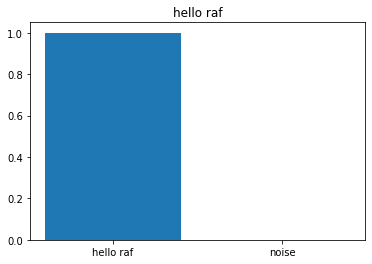

In [ ]:
x = data_dir/'hello raf/raf9.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['hello raf', 'noise']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('hello raf')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [ ]:
export = ExportModel(model)

{'predictions': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 23.248474, -14.449012]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'hello raf'], dtype=object)>}

In [ ]:
!pip install datasets==1.4.1
!pip install soundfile
!pip install jiwer
!pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 KB 8.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
import pandas as pd

ourdata = pd.read_csv("/content/AudioFilesDeepLearning/Audio Files.csv")
ourdata['file'] = ourdata['file'].map(lambda x: "/content/AudioFilesDeepLearning"+x)

In [ ]:
import pandas as pd

ourTestdata = pd.read_csv("/content/AudioFilesDeepLearning/Test Files.csv")
ourTestdata['file'] = ourTestdata['file'].map(lambda x: "/content/AudioFilesDeepLearning"+x)

In [ ]:
from datasets import Dataset

ourdataset =  Dataset.from_pandas(ourdata)
ourTestdataset =  Dataset.from_pandas(ourTestdata)

print(ourdataset)
print(ourTestdataset)

Dataset({
    features: ['file', 'text'],
    num_rows: 20
})
Dataset({
    features: ['file', 'text'],
    num_rows: 12
})


In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_elements(dataset):
    df = pd.DataFrame(dataset)
    display(HTML(df.to_html()))

In [ ]:
show_elements(ourTestdataset.remove_columns(["file"]))

,text
0,what is the weather like in belgrade
1,what is the weather like in belgrade
2,what is the weather like in belgrade
3,what is the weather like in belgrade
4,what is the weather like in belgrade
5,what is the weather like in belgrade
6,post review avatar is a bad movie
7,post review avatar is a bad movie
8,post review avatar is a bad movie
9,post review avatar is a bad movie


In [ ]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [ ]:
ourdataset = ourdataset.map(remove_special_characters)

In [ ]:
ourTestdataset = ourTestdataset.map(remove_special_characters)

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocabs = ourdataset.map(extract_all_chars, batched=True, batch_size=1, keep_in_memory=True)
vocabs

Dataset({
    features: ['all_text', 'file', 'text', 'vocab'],
    num_rows: 20
})

In [ ]:
vocab_list = list(set(vocabs["vocab"][0]))
vocab_list = vocab_list + list(set(vocabs["vocab"][10]))

vocab = []

for i in vocab_list:
  if i not in vocab:
    vocab.append(i)


vocab

['k',
 'r',
 'n',
 'g',
 'i',
 ' ',
 'l',
 'h',
 'e',
 'w',
 'd',
 'a',
 't',
 's',
 'b',
 'p',
 'o',
 'v',
 'm']

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab)}
vocab_dict

{'k': 0,
 'r': 1,
 'n': 2,
 'g': 3,
 'i': 4,
 ' ': 5,
 'l': 6,
 'h': 7,
 'e': 8,
 'w': 9,
 'd': 10,
 'a': 11,
 't': 12,
 's': 13,
 'b': 14,
 'p': 15,
 'o': 16,
 'v': 17,
 'm': 18}

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

21

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [ ]:
tokenizer.save_pretrained("./wav2vec2-base-mine/")

('./wav2vec2-base-mine/tokenizer_config.json',
 './wav2vec2-base-mine/special_tokens_map.json',
 './wav2vec2-base-mine/vocab.json',
 './wav2vec2-base-mine/added_tokens.json')

## **Feature extraction**

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

feature_extractor.save_pretrained("./wav2vec2-base-mine/")

['./wav2vec2-base-mine/preprocessor_config.json']

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

processor.save_pretrained("./wav2vec2-base-mine/")

In [ ]:
ourdataset[0]

{'file': '/content/AudioFilesDeepLearning/audio/audio1.wav',
 'text': 'what is the weather like in belgrade '}

In [ ]:
import librosa

def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = librosa.load(batch["file"], sr=16000)
    batch["speech"] = speech_array
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["text"]
    return batch

In [ ]:
ourdataset = ourdataset.map(speech_file_to_array_fn, num_proc=4)
ourTestdataset = ourTestdataset.map(speech_file_to_array_fn, num_proc=2)

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(ourTestdataset)-1)
print(ourTestdataset[0])
ipd.Audio(data=np.asarray(ourTestdataset[rand_int]["speech"]), rate=ourTestdataset[rand_int]["sampling_rate"])

{'file': '/content/AudioFilesDeepLearning/test/test1.wav', 'sampling_rate': 16000, 'speech': [6.101644612499513e-05, 0.0005663902848027647, 0.0011990803759545088, 0.0008405694970861077, 0.0010977676138281822, 0.0012586445081979036, 0.0006255932385101914, 0.000575166312046349, 0.0006987598026171327, 0.00044891267316415906, 0.0001316131092607975, 0.0008809250430203974, 0.0018246487015858293, 0.0010914396261796355, 0.0007718205451965332, 0.002339839469641447, 0.003620651550590992, 0.0027657400351017714, 0.0009272312163375318, 0.0003480707237031311, 0.0007147404830902815, 0.0010908904951065779, 0.0010120010701939464, 9.146400407189503e-05, 0.0002819826186168939, 0.0005810527363792062, 0.0008903440902940929, 0.0010741930454969406, 0.00019556423649191856, 0.0007046834798529744, 0.0015037416014820337, 0.002427774714305997, 0.0022396212443709373, 0.0016139326617121696, 0.0016968410927802324, 0.0007704459130764008, 1.55425241246121e-05, -0.0005384677788242698, -0.0006393459043465555, -0.0004358

In [ ]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values

    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [ ]:
ourdataset_prepared = ourdataset.map(prepare_dataset, batch_size=1, num_proc=4, batched=True)
ourTestdataset_prepared = ourTestdataset.map(prepare_dataset, batch_size=1, num_proc=2, batched=True)

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:


    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
wer_metric = load_metric("wer")

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    gradient_checkpointing=True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['quantizer.weight_proj.weight', 'project_hid.bias', 'quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.weight', 'project_q.bias', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
model.freeze_feature_extractor()

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./wav2vec2-base-mine/",
  group_by_length=True,
  per_device_train_batch_size=1,
  evaluation_strategy="steps",
  num_train_epochs=250,
  fp16=True,
  save_steps=250,
  eval_steps=500,
  logging_steps=100,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=100,
  save_total_limit=20,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ourdataset_prepared,
    eval_dataset=ourTestdataset_prepared,
    tokenizer=processor.feature_extractor,
)

Using cuda_amp half precision backend


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: sampling_rate, target_text, speech, text, file. If sampling_rate, target_text, speech, text, file are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20
  Num Epochs = 250
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 5000
  Number of trainable parameters = 90195872


Step,Training Loss,Validation Loss,Wer
500,2.731500,2.705581,1.000000
1000,1.650300,0.734342,0.904762
1500,0.124100,0.052155,0.011905
2000,0.076200,0.034744,0.000000
2500,0.050500,0.032900,0.023810
3000,0.039600,0.029509,0.000000
3500,0.036400,0.028524,0.000000
4000,0.024500,0.029613,0.011905
4500,0.031000,0.026825,0.000000
5000,0.006700,0.002050,0.000000


Saving model checkpoint to ./wav2vec2-base-mine/checkpoint-250
Configuration saved in ./wav2vec2-base-mine/checkpoint-250/config.json
Model weights saved in ./wav2vec2-base-mine/checkpoint-250/pytorch_model.bin
Feature extractor saved in ./wav2vec2-base-mine/checkpoint-250/preprocessor_config.json
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: sampling_rate, target_text, speech, text, file. If sampling_rate, target_text, speech, text, file are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation

TrainOutput(global_step=5000, training_loss=0.6540459937572479, metrics={'train_runtime': 791.0305, 'train_samples_per_second': 6.321, 'train_steps_per_second': 6.321, 'total_flos': 1.7291008157472e+17, 'train_loss': 0.6540459937572479, 'epoch': 250.0})

In [ ]:
def map_to_result(batch):
  model.to("cuda")
  input_values = processor(
      batch["speech"],
      sampling_rate=batch["sampling_rate"],
      return_tensors="pt"
  ).input_values.to("cuda")

  with torch.no_grad():
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]

  return batch

In [ ]:
results = ourTestdataset.map(map_to_result)

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["target_text"])))

Test WER: 0.000


In [ ]:
show_elements(results.remove_columns(["speech", "sampling_rate"]))

,file,pred_str,target_text,text
0,/content/AudioFilesDeepLearning/test/test1.wav,what is the weather like in belgrade,what is the weather like in belgrade,what is the weather like in belgrade
1,/content/AudioFilesDeepLearning/test/test2.wav,what is the weather like in belgrade,what is the weather like in belgrade,what is the weather like in belgrade
2,/content/AudioFilesDeepLearning/test/test3.wav,what is the weather like in belgrade,what is the weather like in belgrade,what is the weather like in belgrade
3,/content/AudioFilesDeepLearning/test/test4.wav,what is the weather like in belgrade,what is the weather like in belgrade,what is the weather like in belgrade
4,/content/AudioFilesDeepLearning/test/test5.wav,what is the weather like in belgrade,what is the weather like in belgrade,what is the weather like in belgrade
5,/content/AudioFilesDeepLearning/test/test6.wav,what is the weather like in belgrade,what is the weather like in belgrade,what is the weather like in belgrade
6,/content/AudioFilesDeepLearning/test/test7.wav,post review avatar is a bad movie,post review avatar is a bad movie,post review avatar is a bad movie
7,/content/AudioFilesDeepLearning/test/test8.wav,post review avatar is a bad movie,post review avatar is a bad movie,post review avatar is a bad movie
8,/content/AudioFilesDeepLearning/test/test9.wav,post review avatar is a bad movie,post review avatar is a bad movie,post review avatar is a bad movie
9,/content/AudioFilesDeepLearning/test/test10.wav,post review avatar is a bad movie,post review avatar is a bad movie,post review avatar is a bad movie


In [ ]:
results = results.to_pandas()

In [ ]:
results.head()

,file,pred_str,sampling_rate,speech,target_text,text
0,/content/AudioFilesDeepLearning/test/test1.wav,what is the weather like in belgrade,16000,"[6.101644612499513e-05, 0.0005663902848027647,...",what is the weather like in belgrade,what is the weather like in belgrade
1,/content/AudioFilesDeepLearning/test/test2.wav,what is the weather like in belgrade,16000,"[-0.000261162145761773, 0.0005607734783552587,...",what is the weather like in belgrade,what is the weather like in belgrade
2,/content/AudioFilesDeepLearning/test/test3.wav,what is the weather like in belgrade,16000,"[3.108927558059804e-05, -4.0254370105685666e-0...",what is the weather like in belgrade,what is the weather like in belgrade
3,/content/AudioFilesDeepLearning/test/test4.wav,what is the weather like in belgrade,16000,"[-0.0014944566646590829, -0.002280356362462043...",what is the weather like in belgrade,what is the weather like in belgrade
4,/content/AudioFilesDeepLearning/test/test5.wav,what is the weather like in belgrade,16000,"[-0.0006509513477794826, -0.000970561639405787...",what is the weather like in belgrade,what is the weather like in belgrade


Obrada teksta gde prepoznajemo komande i izvalcimo informacije za dalje komponente

In [ ]:
from IPython.display import Audio, display
import time


str = []
data = []
city = ""

data2 =[]
review = ""

for x in results.index:
  s = (results.loc[x,'pred_str'])
  s.lower()
  str.append(s)


cmd = "what is the weather like in"
cmd2 = "post review"
SPEECH_FILE_CMD = '/content/AudioFilesDeepLearning/cmd.wav'

n=0

for x in str:
  if cmd in x:
    print("Test",n,": is known command")
    tokens = x.split()
    num = len(tokens)
    l = num-6
    for i in range(l):
      city = city + (tokens[6+i])
      city = city +" "
    data.append(city)
    city =""

  elif cmd2 in x:
    print("Test",n,": is known command")
    tokens = x.split()
    num = len(tokens)
    num = num -2
    for i in range(num):
      review = review + (tokens[i+2])
      review = review +" "
    data2.append(review)
    review =""

  else:
    print("Test",n,": is unknown command")
    display(Audio(SPEECH_FILE_CMD, autoplay=True))
  n+=1


Test 0 : is known command
Test 1 : is known command
Test 2 : is known command
Test 3 : is known command
Test 4 : is known command
Test 5 : is known command
Test 6 : is known command
Test 7 : is known command
Test 8 : is known command
Test 9 : is known command
Test 10 : is known command
Test 11 : is known command


Koristimo spoljasni API za live prognozu vremena. Izvucen tekst is audio fajlova prosledjujemo API-u gde nam on vraca prognozu za dati grad

In [ ]:
import requests, json

api_key = "ef5ff4a70c2305d52118300aa05ff9ee"
base_url = "http://api.openweathermap.org/data/2.5/weather?"


for city in data:
  complete_url = base_url + "appid=" + api_key + "&q=" + city

  response = requests.get(complete_url)

  x = response.json()

  if x["cod"] != "404":
      y = x["main"]

      current_temperature=round(y["temp"]-273.15, 0)

      current_pressure = y["pressure"]

      current_humidity = y["humidity"]

      z = x["weather"]

      weather_description = z[0]["description"]
      output = "weather for " + city + " is "+ weather_description +
      " with eight degrees celcius and sixty seven percent humidity"
      print("City:", city,
            "\n temperature (in celcius unit) = " ,
                      current_temperature ,
            "\n atmospheric pressure (in hPa unit) = " ,
                      current_pressure ,
            "\n humidity (in percentage) = " ,
                      current_humidity ,
            "\n description = " ,
                      weather_description)


  else:
      print(" City Not Found ")

City: belgrade  
 temperature (in celcius unit) =  8.0 
 atmospheric pressure (in hPa unit) =  1013 
 humidity (in percentage) =  67 
 description =  clear sky
City: belgrade  
 temperature (in celcius unit) =  8.0 
 atmospheric pressure (in hPa unit) =  1013 
 humidity (in percentage) =  67 
 description =  clear sky
City: belgrade  
 temperature (in celcius unit) =  8.0 
 atmospheric pressure (in hPa unit) =  1013 
 humidity (in percentage) =  67 
 description =  clear sky
City: belgrade  
 temperature (in celcius unit) =  8.0 
 atmospheric pressure (in hPa unit) =  1013 
 humidity (in percentage) =  67 
 description =  clear sky
City: belgrade  
 temperature (in celcius unit) =  8.0 
 atmospheric pressure (in hPa unit) =  1013 
 humidity (in percentage) =  67 
 description =  clear sky
City: belgrade  
 temperature (in celcius unit) =  8.0 
 atmospheric pressure (in hPa unit) =  1013 
 humidity (in percentage) =  67 
 description =  clear sky


Za sentiment analysis korsiticemo vec postojeci BERT model i dodtano trenirati na datasetu recenzija filmova sa imbd

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install datasets transformers huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Smanjujemo data set je. Jer orignialni je dosta velik.

In [ ]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(5000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(500))])

Koristimo DistilBERT tokenizer

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Delimo podatke na training i test

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Da bi ubrzali proces treniranja koristimo data_collator da pretovrimo trening podatke u PyTorch tenzore i konkateniramo za odgovarajucom kolicnom Paddinga

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Definisemo DistilBERT kao bazu naseg modela

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


Definisemo trening argumente

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "my_movie_review_model"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/content/my_movie_review_model is already a clone of https://huggingface.co/vanja98/my_movie_review_model. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 626
  Number of trainable parameters = 66955010


Step,Training Loss
500,0.135500


Saving model checkpoint to my_movie_review_model/checkpoint-313
Configuration saved in my_movie_review_model/checkpoint-313/config.json
Model weights saved in my_movie_review_model/checkpoint-313/pytorch_model.bin
tokenizer config file saved in my_movie_review_model/checkpoint-313/tokenizer_config.json
Special tokens file saved in my_movie_review_model/checkpoint-313/special_tokens_map.json
tokenizer config file saved in my_movie_review_model/tokenizer_config.json
Special tokens file saved in my_movie_review_model/special_tokens_map.json
Several commits (2) will be pushed upstream.
Saving model checkpoint to my_movie_review_model/checkpoint-626
Configuration saved in my_movie_review_model/checkpoint-626/config.json
Model weights saved in my_movie_review_model/checkpoint-626/pytorch_model.bin
tokenizer config file saved in my_movie_review_model/checkpoint-626/tokenizer_config.json
Special tokens file saved in my_movie_review_model/checkpoint-626/special_tokens_map.json


Training comple

TrainOutput(global_step=626, training_loss=0.13366052060843275, metrics={'train_runtime': 490.123, 'train_samples_per_second': 20.403, 'train_steps_per_second': 1.277, 'total_flos': 1305886383784992.0, 'train_loss': 0.13366052060843275, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 16


<ipython-input-10-b1430cee0b64>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.3664727210998535,
 'eval_accuracy': 0.908,
 'eval_f1': 0.9094488188976377,
 'eval_runtime': 8.5289,
 'eval_samples_per_second': 58.624,
 'eval_steps_per_second': 3.752,
 'epoch': 2.0}

uploadujemo model na huggingface hub

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to my_movie_review_model
Configuration saved in my_movie_review_model/config.json
Model weights saved in my_movie_review_model/pytorch_model.bin
tokenizer config file saved in my_movie_review_model/tokenizer_config.json
Special tokens file saved in my_movie_review_model/special_tokens_map.json
Several commits (3) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.30k/255M [00:00<?, ?B/s]

Upload file runs/Jan08_22-27-24_d63ee629d92f/events.out.tfevents.1673216850.d63ee629d92f.173.2:  80%|######## …

Upload file runs/Jan08_22-27-24_d63ee629d92f/events.out.tfevents.1673217373.d63ee629d92f.173.4: 100%|#########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/vanja98/my_movie_review_model
   cadab5b..d388e9c  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/vanja98/my_movie_review_model
   cadab5b..d388e9c  main -> main

To https://huggingface.co/vanja98/my_movie_review_model
   d388e9c..9df2cb7  main -> main

   d388e9c..9df2cb7  main -> main



'https://huggingface.co/vanja98/my_movie_review_model/commit/d388e9c1f9939153c61845b17070bc0a67e2bb2c'

Uz pomoc pipeline testiramo nas model

In [ ]:
from transformers import pipeline

sentiment_model = pipeline(model="vanja98/my_movie_review_model")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vanja98--my_movie_review_model/snapshots/9df2cb7a68965cf68d805dcfbab6ed6766c87a73/config.json
Model config DistilBertConfig {
  "_name_or_path": "vanja98/my_movie_review_model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vanja98--my_movie_review_model/snapshots/9df2cb7a68965cf68d805dcfbab6ed676

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--vanja98--my_movie_review_model/snapshots/9df2cb7a68965cf68d805dcfbab6ed6766c87a73/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at vanja98/my_movie_review_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--vanja98--my_movie_review_model/snapshots/9df2cb7a68965cf68d805dcfbab6ed6766c87a73/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--vanja98--my_movie_review_model/snapshots/9df2cb7a68965cf68d805dcfbab6ed6766c87a73/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--vanja98--my_movie_review_model/snapshots/9df2cb7a68965cf68d805dcfbab6ed6766c87a73/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--vanja98--my_movie_review_model/snapshots/9df2cb7a68965cf68d805dcfbab6ed6766c87a73/tokenizer_config.json


Iz responsa izvucemo za pojedinacne upite da li je pozitivno ili negativno i vratimo korisniku odgovoarajuci odgovor

In [ ]:
from IPython.display import Audio, display
import time

demo = ["I love this movie", "This movie sucks!"]

score = sentiment_model(data2)

SPEECH_FILE_POS = '/content/AudioFilesDeepLearning/pos.wav'
SPEECH_FILE_NEG = '/content/AudioFilesDeepLearning/neg.wav'

for s in score:
  label = s['label']
  if label == "LABEL_1":
    print("positive")
    print(s)
    display(Audio(SPEECH_FILE_POS, autoplay=True))
  else:
    print("negative")
    print(s)
    display(Audio(SPEECH_FILE_NEG, autoplay=True))
  time.sleep(6)

In [ ]:
!pip3 install deep_phonemizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.17-py3-none-any.whl size=29727 sha256=f20d1506956e0f122f69dc9f6bce8ad0ade82165705faec2262ae2385240b1fc
  Stored in directory: /root/.cache/pip/wheels/e4/cc/ce/e329d15bd6374b9bcdc717d00c4d0f934c3ca2091ebf0a1968
Successfully built deep_phonemizer


Speech 2 Text

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt

import IPython

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

1.13.0+cu116
0.13.0+cu116


In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

#text = "Hello world! Belgrade is beautiful"

with torch.inference_mode():
  processed, lengths = processor(output)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_wavernn.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_wavernn.wav"))